### Tesi M.N.A

#### Importing tools and functions

In [1]:
%load_ext autoreload
%autoreload 2
from Tools import *

#### loading data

In [72]:
rock_cropout, mean_elev, stazioni, unconsolidated, rocks, coastline = load_data()

In [73]:
#RANDOM SAMPLING OF CROPOUT BIGGER THEN 2500 m^2 (50*50) square
rock_cropout = rock_cropout[rock_cropout.geometry.area > (50*50)].sample(frac=0.33)

#### get elevations of rock_cropouts

In [74]:
rock_cropout['elevation'] = get_elevation(rock_cropout, mean_elev)

#### get basemap projections of all the data we want to visualize

In [75]:
viz_cropout, viz_stazioni, viz_rocks, viz_uncons = get_basemap_projection([rock_cropout, stazioni, rocks, unconsolidated])

#### Visualize initial data

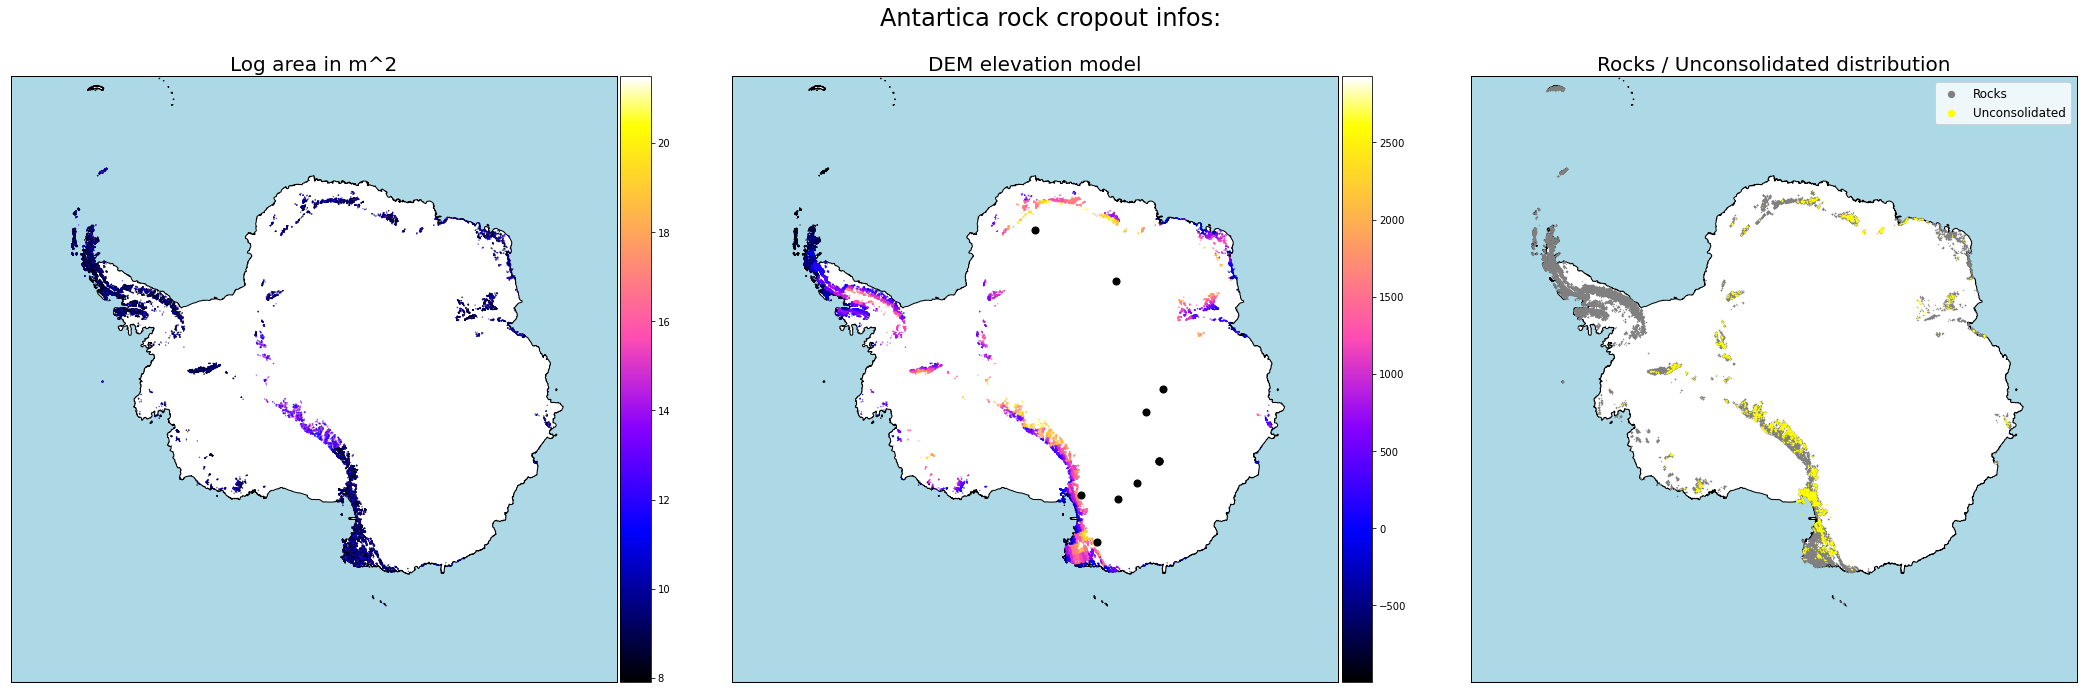

In [76]:
visualize_exploratory_data(rock_cropout, viz_cropout, viz_stazioni, viz_rocks, viz_uncons)

#### Get clustering

In [ ]:
import cProfile
import pstats

with cProfile.Profile() as pr:
    get_clusters(25, rock_cropout, viz_cropout, viz_stazioni, cluster_data.iloc[:,1:])

stats = pstats.Stats(pr)
stats.sort_stats(pstats.SortKey.TIME)
stats.dump_stats(filename='profiling.prof')

In [ ]:
# No area, è abbastanza inutile
cluster_data = get_cluster_data(rock_cropout)

In [ ]:
clusters = get_clusters(35, rock_cropout, viz_cropout, viz_stazioni, cluster_data.iloc[:,1:])

In [ ]:
stazioni['distance_from_coastline(km)']     = get_distance_from_coastline(stazioni, coastline)
stazioni['nearest_cluster(num)']            = stazioni.geometry.apply(lambda x: clusters.iloc[np.argmin([x.distance(geom.centroid) / 1000 for geom in clusters.geometry])].cluster_num )
## TODO Check distanza dal centroide e distanza dal cropout più vicino del cluster
stazioni['distance_to_nearest_cluster(km)'] = stazioni.geometry.apply(lambda x: np.around(x.distance(clusters.iloc[np.argmin([x.distance(geom.centroid) / 1000 for geom in clusters.geometry])].geometry.centroid) / 1000,2 ))
stazioni['nearest_cropout(km)']             = stazioni.geometry.apply(lambda x: np.around(np.min([x.distance(geom) / 1000 for geom in rock_cropout.geometry]), 2) )
##
stazioni['cropout_area_within_500km']       = stazioni.geometry.apply(lambda x: get_total_cropout_area_under_radius(x, rock_cropout.geometry, 500))
stazioni['cropout_area_within_1000km']      = stazioni.geometry.apply(lambda x: get_total_cropout_area_under_radius(x, rock_cropout.geometry, 1000))

In [ ]:
stazioni

### VIZs

In [ ]:
px.scatter(clusters, x="cluster_num", y="elevation", size='area_km2', color='elevation_range',width=1000, height=500)

In [ ]:
px.scatter(stazioni, x="distance_from_coastline(km)", y="distance_to_nearest_cluster(km)", size='cropout_area_within_1000km', color='dust_conc_(ppb)',width=1000, height=500)

In [ ]:
px.scatter(stazioni, x="dust_conc_(ppb)", y="cropout_area_within_1000km", size='distance_from_coastline(km)', color='altitude',width=1000, height=500)

In [2]:
import pandas as pd
from glob import glob
from datetime import timedelta
from tqdm import tqdm
import numpy as np

### ADD STATION CODE AS ID

In [3]:
def get_data():
    filenames = glob('data/clima/amrc/*/*.dat')
    names = ['station', 'timestamp', 'latitude', 'longitude', 'elevation', 'temperature', 'pressure',
                   'wind_speed', 'wind_direction', 'relative_humidity', 'vertical_temperature_difference']
    count = 0
    skipped = 0
    rows = []
    for file in tqdm(filenames[:]):
        with open(file) as f:
            lines = f.readlines()
            
            infos = [x for x in lines[0].split(' ') if len(x) > 0]
            station = lines[0].split(':')[1].strip('\n').replace(' ','')
            year = '19' + str(infos[1])
            if int(infos[1]) <= 21:
                year = '20' + str(infos[1])
            month = infos[0]
            base_dt = pd.Timestamp(year+'/'+month)
            line = lines[1].lower()
            try: latitude = line.split(':')[1].split('l')[0].lower().replace(' ','')
            except:  latitude = None
            try: longitude = line.split(':')[2].split('el')[0].lower().replace(' ','')
            except: longitude = None
            try: elevation = line.split(':')[3].replace(' ','').strip('m\n')
            except: elevation = None
            
            lines = lines[2:]
            for i in range(len(lines)-1):
                try:
                    line = lines[i]
                    infos = [x for x in line.split(' ') if len(x) > 0]
                    temperature = float(infos[0])
                    pressure = float(infos[1])
                    wind_speed = float(infos[2])
                    wind_direction = float(infos[3].strip('\n'))
                    relative_humidity = None
                    vertical_temperature_difference = None
                    if len(infos) == 6:
                        relative_humidity = float(infos[4])
                        vertical_temperature_difference = float(infos[5].strip('\n'))
                    timestamp = base_dt + timedelta(hours=3*(i-2))
                    row = [station, timestamp, latitude, longitude, elevation, temperature, pressure,
                       wind_speed, wind_direction, relative_humidity, vertical_temperature_difference]
                    rows.append(row)
                    count += 1
                except Exception as e:
                    skipped += 1
    print("skipped : ", skipped)
    amrc =  pd.DataFrame(rows, columns=names).replace(444.0, np.nan).replace('', np.nan)
    def long_cast(long):
        if type(long) == str:
            if long[-1] == 'e':
                return float(long[:-1])
            else:
                return -float(long[:-1])
        else:
            return None
    amrc.latitude = amrc.latitude.apply(lambda x: -float(x[:-1]) if type(x) == str else None)
    amrc.longitude = amrc.longitude.apply(lambda x: long_cast(x))
    return amrc

###### Dome Fuji (8904) is an exception to this, where the relative humidity column is instead lower temperature (C).

In [4]:
amrc = get_data()
amrc

100%|███████████████████████████████████████████████████████████████████████████| 15417/15417 [02:10<00:00, 118.00it/s]


skipped :  8


,station,timestamp,latitude,longitude,elevation,temperature,pressure,wind_speed,wind_direction,relative_humidity,vertical_temperature_difference
0,8900D-17,1979-12-31 18:00:00,-66.70,139.70,438,NaN,NaN,NaN,NaN,NaN,NaN
1,8900D-17,1979-12-31 21:00:00,-66.70,139.70,438,NaN,NaN,NaN,NaN,NaN,NaN
2,8900D-17,1980-01-01 00:00:00,-66.70,139.70,438,NaN,NaN,NaN,NaN,NaN,NaN
3,8900D-17,1980-01-01 03:00:00,-66.70,139.70,438,NaN,NaN,NaN,NaN,NaN,NaN
4,8900D-17,1980-01-01 06:00:00,-66.70,139.70,438,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3771527,8989DomeCII,2021-05-31 00:00:00,-75.11,123.35,3250,-62.5,648.9,1.8,257.0,NaN,NaN
3771528,8989DomeCII,2021-05-31 03:00:00,-75.11,123.35,3250,-61.4,647.7,2.5,215.0,NaN,NaN
3771529,8989DomeCII,2021-05-31 06:00:00,-75.11,123.35,3250,-62.4,646.8,1.5,228.0,NaN,NaN
3771530,8989DomeCII,2021-05-31 09:00:00,-75.11,123.35,3250,-65.0,645.7,1.0,229.0,NaN,NaN


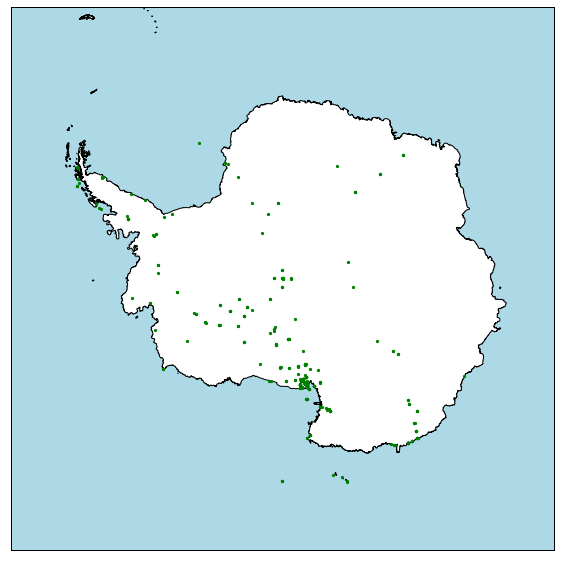

In [6]:
viz1 = amrc.groupby('station').agg({'latitude' : 'mean', 'longitude' : 'mean'}).reset_index()
basemap = get_basemap()
points_x, points_y = basemap(viz1.longitude, viz1.latitude)
viz1_proj = pd.DataFrame({'x': points_x, 'y': points_y})
fig, ax = plt.subplots(figsize=(10, 10))
basemap = viz_init(ax)
basemap.scatter(viz1_proj.x, viz1_proj.y, color = 'green', zorder=5, s=5, ax=ax)